# Covid-19:analysis of a modified SEIR model

The following cell simulates a COVID-19 outbreak in campus population of size N starting with one infectious case.  The following parameter values for an extended SEIR model are considered.

| Parameter |  Symbol  | Values 
| :------- | :-- | :-----------: 
| fraction of asymptomatic carriers | $\alpha$ | 0.67
| infectivity of asymptomatic carriers.| $\beta_{a}$ | 0.333 
| infectivity of presymptomatic carriers | $\beta_{p}$  | 0.5
| transition rate from exposed to infectious | $\sigma$ | $\frac{1}{3}$ 
| transition rate of asymptomatic carriers to recovery or hospitalization| $\gamma_{a}$  | $\frac{1}{8}$ 
| transition rate of presymptomatics to recovery or hospitalization | $\gamma_{p}$ | $\frac{1}{12}$
| detection probabilities of asymptomatic carriers  | $\nu_{a}$ | $\frac{1}{3}$
| detection probabilities of symptomatic carriers | $\nu_{p}$ | $\frac{1}{2}$
| intervention factor due to social distancing | $u$ | we vary it
| intervention factor due to testing-quarantining(or rate of testing-quarantining) | $r$ | we vary it

To run the model, adjust the sliders below, then click the run arrow that appears in the left marging. The charts will automatically update when the sliders are readjusted.

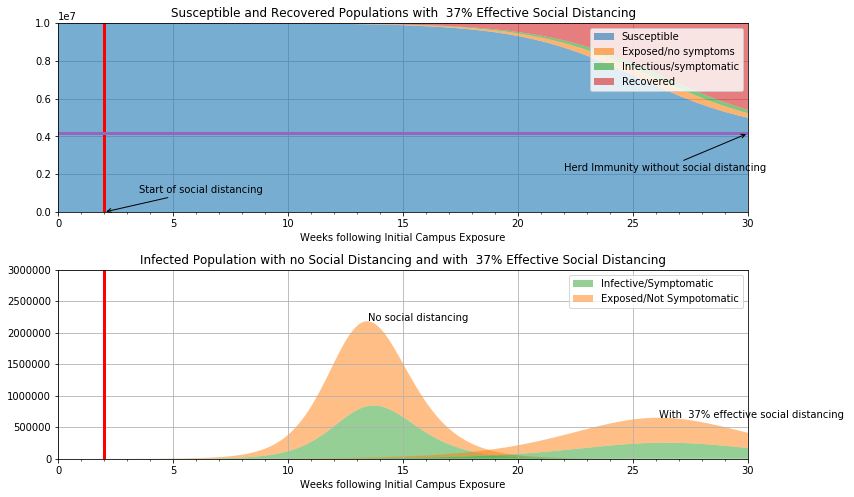

In [4]:
#@title SEIR Model with Social Distancing { run: "auto" }
#@markdown 
#@markdown Reproduction number
R0 = 2.4 #@param {type:"slider", min:0.9, max:5, step:0.1}
#@markdown Disease periods in days
t_incubation = 5.1 #@param {type:"slider", min:1, max:14, step:0.1}
t_infective = 3.3 #@param {type:"slider", min:1, max:14, step:0.1}
#@markdown Population Size
N = 10**7 #@param {type:"slider", min:1000, max:350000, step: 1000}
#@markdown Initial number exposed
n = 50 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Start of social distancing following exposure (weeks)
t_social_distancing = 2 #@param {type:"slider", min:0, max:30, step:0.1}
#@markdown Effectiveness of social distancing (0 to 100%)
u_social_distancing = 37 #@param {type:"slider", min:0, max:100, step:1}

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

# initial number of infected and recovered individuals
e_initial = n/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

def step(t):
    return 1 if t >= 7*t_social_distancing else 0

# SEIR model differential equations.
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u*step(t)/100)*beta * s * i
    dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 210, 210)
x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

# plot the data
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[0].set_xlabel('Weeks following Initial Campus Exposure')
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'Susceptible', 
    'Exposed/no symptoms', 
    'Infectious/symptomatic',
    'Recovered'], 
    loc='best')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
ax[0].annotate("Start of social distancing",
    (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Herd Immunity without social distancing",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[1].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[1].set_xlim(0, t[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Weeks following Initial Campus Exposure')
ax[1].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

### The extended SEIR Basics
The main difference between this model and the normal SIER model is that we incorporate the fact that asymptomatic individuals play a significant role in the transmission of Covid-19.
We divide the population of size N into
eight compartments:
1. S = Susceptible individuals.
2. E = Exposed but not yet contagious individuals.
3. $I_a$ = Asymptomatic, either develop no symptoms or
mild symptoms.
4. $I_p$ = Presymptomatic, those who would eventually
develop strong symptoms.
5. $U_a$ = Undetected asymptomatic individuals who have
recovered.
6. $D_a$ = Asymptomatic individuals who are detected
because of directed testing-quarantining, may have mild
symptoms, and would have been placed under home isolation (few in India).
7. $U_p$ = Presymptomatic individuals who are detected
at a late stage after they develop serious symptoms and
report to hospitals.
8. $D_p$ = Presymptomatic individuals who are detected
because of directed testing-quarantining.
$$N = S +E +I_a +I_p +U_a +D_a + U_p + D_p$$
The dynamics are given by these equations.
\begin{align*} 
\dot{S} &= -\dfrac{u(\beta_aI_a + \beta_pI_p)}{N}S\\ 
\dot{E} &= \dfrac{u(\beta_aI_a + \beta_pI_p)}{N}S-\sigma E\\
\dot{I_a} &= \alpha\sigma E-\gamma_a I_a-r\nu_a I_a \\
\dot{I_p} &= (1-\alpha)\sigma E-\gamma_p I_p-r\nu_p I_p \\
\dot{U_a} &= \gamma_a I_a \\
\dot{U_p} &= \gamma_p I_p \\
\dot{D_a} &= r\nu_a I_a \\
\dot{D_p} &= r\nu_p I_p
\end{align*}
Where the paramenter symbols refer to their respective paramenters given below.

| Parameter |  Symbol  | Values 
| :------- | :-- | :-----------: 
| fraction of asymptomatic carriers | $\alpha$ | 0.67
| infectivity of asymptomatic carriers.| $\beta_{a}$ | 0.333 
| infectivity of presymptomatic carriers | $\beta_{p}$  | 0.5
| transition rate from exposed to infectious | $\sigma$ | $\frac{1}{3}$ 
| transition rate of asymptomatic carriers to recovery or hospitalization| $\gamma_{a}$  | $\frac{1}{8}$ 
| transition rate of presymptomatics to recovery or hospitalization | $\gamma_{p}$ | $\frac{1}{12}$
| detection probabilities of asymptomatic carriers  | $\nu_{a}$ | $\frac{1}{3}$
| detection probabilities of symptomatic carriers | $\nu_{p}$ | $\frac{1}{2}$
| intervention factor due to social distancing | $u$ | we vary it
| intervention factor due to testing-quarantining(or rate of testing-quarantining) | $r$ | we vary it


### References:
1. Arghya Das, Abhishek Dhar, Srashti Goyal and Anupam Kundu. 
$\textit{Covid-19: analysis of a modified SEIR model, a comparison of different intervention strategies and projections for India}$. 
    arXiv:2005.11511 $[$q-bio.PE$]$, 2020.
    
    [$\texttt{https://arxiv.org/abs/2005.11511}$](https://arxiv.org/abs/2005.11511)
2. Code by Jeffrey Kantor [from here](https://jckantor.github.io/CBE30338/03.09-COVID-19.html)
<p><a href="https://colab.research.google.com/drive/1ddb_0swsq9MRKyHrzflCzeF8Tqqmp24H#scrollTo=0lBOtduur4Ps"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>
